<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [274]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import extensions

In [275]:
import swmmio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Explore model data

In [276]:
model = swmmio.Model('example.inp')
df_links = model.links.dataframe
df_subcatchments = model.subcatchments.dataframe

example.rpt failed to initialize
local variable 'swmm_version' referenced before assignment


In [277]:
df_links[:2]

,InletNode,OutletNode,...,Barrels,coords
Name,,,,,
C3,J1,J3,...,1,"[(777189.014, 592583.674), (777197.821, 592564.501)]"
C4,J3,O4,...,1,"[(777197.821, 592564.501), (777203.103, 592557.13)]"


In [278]:
df_subcatchments[:2]

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777175.934, 592588.598), (777185.333, 592588.986), (777185.453, 592579.676), (777176.173, 592579.527), (777175.934, 592588.717), (777175.934, 592588.598)]"


In [279]:
df_links.describe().T

,count,mean,...,75%,max
Length,2.0,50.00,...,50.00,50.00
Roughness,2.0,0.01,...,0.01,0.01
InOffset,2.0,0.00,...,0.00,0.00
OutOffset,2.0,0.00,...,0.00,0.00
InitFlow,2.0,0.00,...,0.00,0.00
MaxFlow,2.0,0.00,...,0.00,0.00
Geom1,2.0,1.10,...,1.15,1.20
Geom2,2.0,0.00,...,0.00,0.00
Geom3,2.0,0.00,...,0.00,0.00
Geom4,2.0,0.00,...,0.00,0.00


In [280]:
df_subcatchments.describe()

,Raingage,Area,...,S-Perv,PctZero
count,1.0,1.0,...,1.00,1.0
mean,1.0,5.0,...,0.05,25.0
std,NaN,NaN,...,NaN,NaN
min,1.0,5.0,...,0.05,25.0
25%,1.0,5.0,...,0.05,25.0
50%,1.0,5.0,...,0.05,25.0
75%,1.0,5.0,...,0.05,25.0
max,1.0,5.0,...,0.05,25.0


# Prepare methoed for sumulation

In [281]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []
        self.peak_flow = []
        self.peak_flow_date = []
        self.peak_velocity = []
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []
        # peak_depth - maksymalna wysokość napełnienia kanału [m]
        # peak_flow - maksymaly przepływ [m3/s]
        # peak_velocity - maksymalna prędkość przepływu [m/s]

class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self.slope = []
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def simulation(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        counter = min_slope
        while counter < max_slope:
            self.slope.append(counter)
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                    conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                for key in vars(self.pipe_data):
                    getattr(self.pipe_data, key).append(conduit_stats[key])
                for key in vars(self.catchment_data):
                    getattr(self.catchment_data, key).append(catchment_stats[key])
            counter += step
        return None

# Do simulation

In [323]:
pipe = Analyse()
pipe.simulation("C3", "S1", step=0.5)

# Prepare dataframe



In [324]:
data = {"slope": pipe.slope, **vars(pipe.pipe_data), **vars(pipe.catchment_data)}
df_raw = pd.DataFrame(data=data)

# Data for work

In [325]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   slope                  200 non-null    float64
 1   flow_turn_sign         200 non-null    int64  
 2   flow_turns             200 non-null    int64  
 3   peak_depth             200 non-null    float64
 4   peak_flow              200 non-null    float64
 5   peak_flow_date         200 non-null    float64
 6   peak_velocity          200 non-null    float64
 7   time_capacity_limited  200 non-null    float64
 8   time_courant_crit      200 non-null    float64
 9   time_full_downstream   200 non-null    float64
 10  time_full_flow         200 non-null    float64
 11  time_full_upstream     200 non-null    float64
 12  time_normal_flow       200 non-null    float64
 13  runoff                 200 non-null    float64
 14  peak_runoff_rate       200 non-null    float64
 15  infilt

In [326]:
df.head()

,slope,flow_turn_sign,...,infiltration,evaporation
0,0.1,1,...,69.115588,0.0
1,0.6,-1,...,54.448428,0.0
2,1.1,1,...,50.938596,0.0
3,1.6,1,...,49.042774,0.0
4,2.1,1,...,47.790176,0.0


In [327]:
df.shape

(200, 17)

In [328]:
df.describe().T

,count,mean,...,75%,max
slope,200.0,49.850000,...,74.725000,99.600000
flow_turn_sign,200.0,0.960000,...,1.000000,1.000000
flow_turns,200.0,174.970000,...,175.000000,213.000000
peak_depth,200.0,0.623556,...,0.623572,0.623586
peak_flow,200.0,1.542517,...,1.542569,1.542621
peak_flow_date,200.0,44729.041542,...,44729.041532,44729.041739
peak_velocity,200.0,3.046311,...,3.046497,3.050333
time_capacity_limited,200.0,0.000000,...,0.000000,0.000000
time_courant_crit,200.0,0.041389,...,0.041667,0.042500
time_full_downstream,200.0,0.000000,...,0.000000,0.000000


# Remove unused columns

In [329]:
df.columns

Index(['slope', 'flow_turn_sign', 'flow_turns', 'peak_depth', 'peak_flow',
       'peak_flow_date', 'peak_velocity', 'time_capacity_limited',
       'time_courant_crit', 'time_full_downstream', 'time_full_flow',
       'time_full_upstream', 'time_normal_flow', 'runoff', 'peak_runoff_rate',
       'infiltration', 'evaporation'],
      dtype='object')

In [330]:
df.head()

,slope,flow_turn_sign,...,infiltration,evaporation
0,0.1,1,...,69.115588,0.0
1,0.6,-1,...,54.448428,0.0
2,1.1,1,...,50.938596,0.0
3,1.6,1,...,49.042774,0.0
4,2.1,1,...,47.790176,0.0


In [331]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

,slope,peak_depth,...,infiltration,evaporation
0,0.1,0.622044,...,69.115588,0.0
1,0.6,0.623468,...,54.448428,0.0
2,1.1,0.623469,...,50.938596,0.0
3,1.6,0.623486,...,49.042774,0.0
4,2.1,0.623524,...,47.790176,0.0


# export to excel

In [332]:
df.to_excel('data.xlsx')

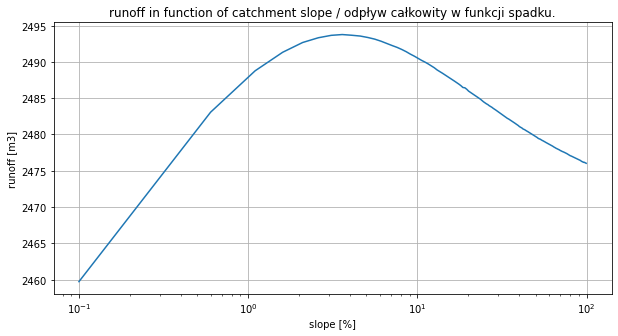

In [333]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('runoff in function of catchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('slope [%]')
plt.ylabel('runoff [m3]')
plt.grid(True)
plt.show()

# Plot peak runoff rate data

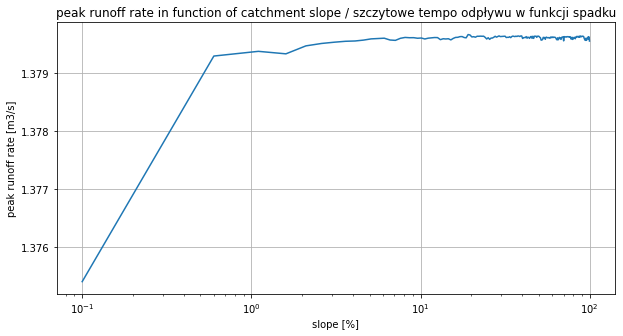

In [334]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('peak runoff rate in function of catchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('slope [%]')
plt.ylabel('peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

# Plot infiltration data

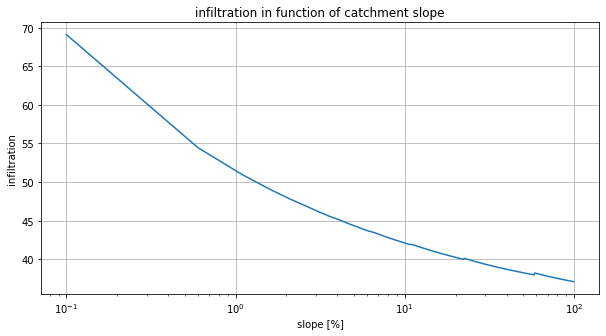

In [335]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('infiltration in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('infiltration')
plt.grid(True)
plt.show()

# Plot correlation maximal flow in pipe with subcatchment slope

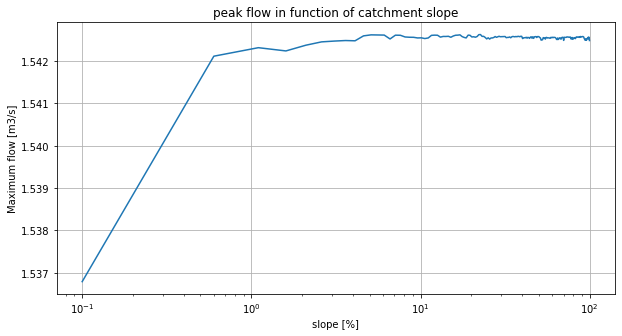

In [336]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('peak flow in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

# Plot correlation maximal velocity in pipe and subcatchment slope

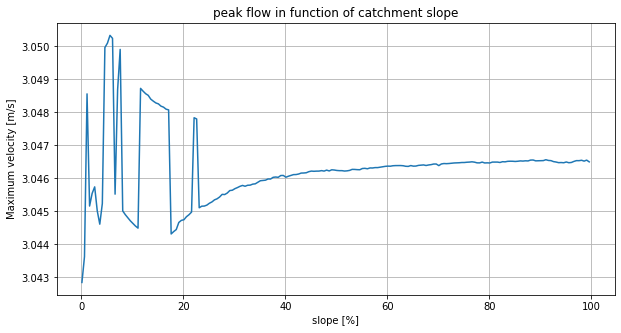

In [337]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_velocity'])
plt.title('peak flow in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

# Plot correlation maximal pipe filling and subcatchment slope.

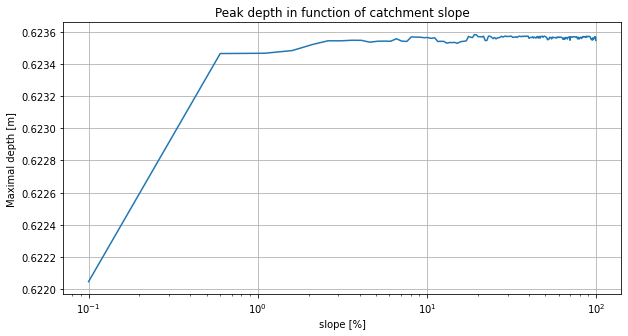

In [338]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_depth'])
plt.title('Peak depth in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

In [ ]:
!jupyter nbconvert --to pdf /content/KNN.ipynb